## OVERVIEW

As your consultant, I will initiate this project by adhering strictly to the CRoss-Industry Standard Process for Data Mining framework, beginning with a thorough understanding of your business.
My primary objective is to translate your business need, identifying the key factors influencing used car prices constructing a highly accurate Prediction model. This model will be developed using the provided 426K car dataset.

### Business Understanding

The objective of this exercise is to provide an accurate and explanable car price prediction model by 
identifying key factors that influence vehicle pricing by leverage  provided vehicle dataset of 426,000 records. The project will follow the CRISP-DM framework to ensure alignment with business objectives and requirements. The solution will enusre there is right analytical rigor ensuring the model is well trained and quality tested for repeatable outcomes to support pricing decisions based oninsights and data-driven strategy.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [423]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [424]:
used_cars_data =  pd.read_csv('data/vehicles.csv')
used_cars_data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [425]:
used_cars_data.shape

(426880, 18)

In [426]:
# car dataset summary
car_summary = pd.DataFrame({
        "dtype": used_cars_data.dtypes.astype(str),
        "non_null_count": used_cars_data.notna().sum(),
        "null_count": used_cars_data.isna().sum(),
        "unique_values": used_cars_data.nunique()
    })

car_summary["percent_missing"] = (car_summary["null_count"] / len(used_cars_data) * 100).round(2)
car_summary.reset_index()
car_summary = car_summary.rename(columns={"index": "column"})
car_summary

,dtype,non_null_count,null_count,unique_values,percent_missing
id,int64,426880,0,426880,0.00
region,object,426880,0,404,0.00
price,int64,426880,0,15655,0.00
year,float64,425675,1205,114,0.28
manufacturer,object,409234,17646,42,4.13
model,object,421603,5277,29649,1.24
condition,object,252776,174104,6,40.79
cylinders,object,249202,177678,8,41.62
fuel,object,423867,3013,5,0.71
odometer,float64,422480,4400,104870,1.03


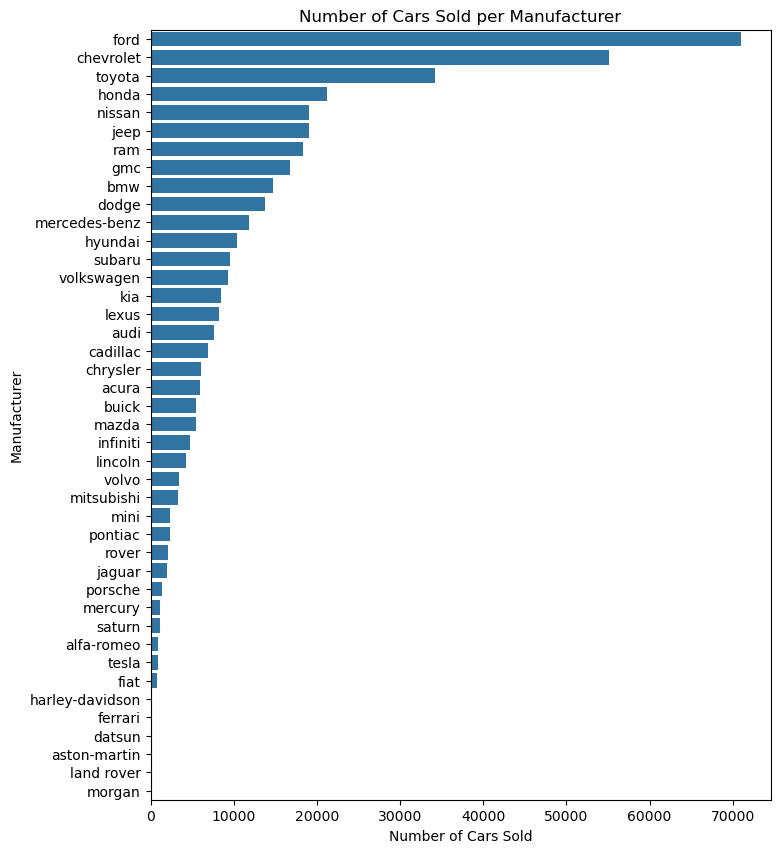

In [427]:

# Plot to show the number of cars sold per manufacturer

plt.figure(figsize=(8, 10))

manufacturer_count = (
    used_cars_data["manufacturer"]
    .value_counts()
    .reset_index()
)
manufacturer_count.columns =  ["manufacturer", "count"]

sns.barplot(
    data = manufacturer_count,
    y='manufacturer',
    x='count'
)
plt.title("Number of Cars Sold per Manufacturer")
plt.xlabel("Number of Cars Sold")
plt.ylabel("Manufacturer")
plt.savefig('cars_sold_per_manufacturer.png', dpi=300, bbox_inches='tight')
plt.show()

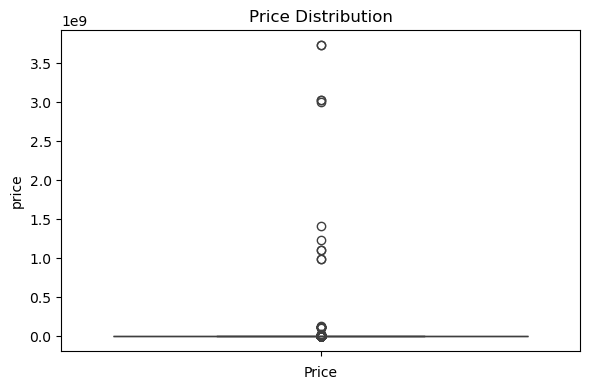

In [428]:
# Price distribution observation with a plot

plt.figure(figsize=(6, 4))
sns.boxplot(y=used_cars_data['price'])
plt.title("Price Distribution")
plt.xlabel("Price")
plt.tight_layout()
plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

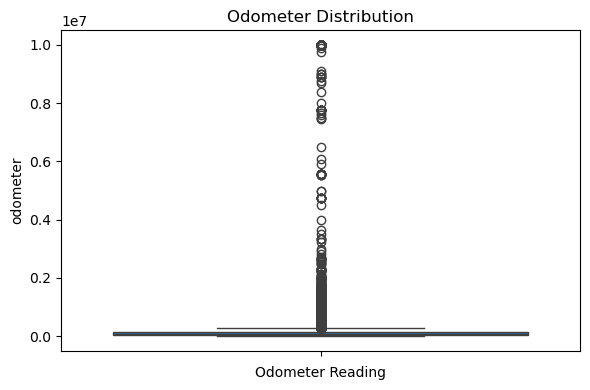

In [429]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=used_cars_data['odometer'])
plt.title("Odometer Distribution")
plt.xlabel("Odometer Reading")
plt.tight_layout()
plt.savefig('odometer_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Data Understanding and Observations

* The used car dataset contains 426,880 records and 18 columns, representing a large and diverse vehicle inventory.
* The id column appears to be a database primary key and does not provide analytical value.
* The VIN column is unique to each vehicle and carries no semantic meaning for price prediction.
* Key attributes expected to strongly influence vehicle price include model, year, and odometer.
* Additional features such as vehicle size, condition, fuel type, cylinders, and transmission are also likely to impact pricing.
* Several columns contain substantial missing values, with drive, size, condition, and cylinders missing in over 30% of records, requiring careful handling.
* The dataset contains significant outliers in both price and odometer values that could skew model results if left untreated.
* Price distribution is heavily right-skewed, with most vehicles priced in the thousands or tens of thousands, while a small number of extreme values inflate the upper range.
* Odometer values show a long-tailed distribution, with a few unrealistically high readings stretching the scale beyond typical vehicle usage.
* A systematic approach to handling missing data, feature level and outlier treatment is essential for building a reliable pricing model.


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 


### Below are steps undertaken for prepartion of the data
* Initial modeling using the full dataset resulted in poor predictive performance across all models, indicating data quality issues.
* Filtering the dataset and removing records with excessive missing values significantly improved prediction accuracy.
* Retaining high-missing columns with indicator flags did not materially improve model performance.
* Records containing missing values in critical fields were removed, resulting in approximately 73% of the original data being excluded to ensure data integrity.
* Outlier treatment was applied to the price and odometer columns using lower and upper quartile thresholds to reduce noise and extreme value influence.
* Logarithmic transformations were applied to the price and odometer columns to address skewness and stabilize variance.
* Numerical features were scaled to ensure comparability across features and numerical stability during model training.
* Categorical features were encoded to preserve category-level information for modeling.
* As an alternative modeling approach, categorical features were also manually converted to numeric identifiers to evaluate performance differences.

In [431]:
# Remove Columns ID and VIN as they are unique to each car and has no semantic meeting
# Drop the column size as more than 70% of data is missing
used_cars_data = used_cars_data.drop(
    columns=["id", "VIN", "size"],
    errors="ignore"
)

In [432]:
# Intially didn't want to delete Null/NaN values as there were
# 322,534 records that have Null/NaN Values which is apprximately 72% of total data
# But the all three models - Linear, Ridge and Lasso) didn't predict well full data
#  so went along deleteing null data

used_cars_data_copy = used_cars_data.copy()
total_rows= used_cars_data_copy.dropna().shape[0]
dropped_rows = used_cars_data.shape[0]-total_rows
percentage_nulls = f"{((dropped_rows / used_cars_data.shape[0]) * 100):.2f}"
print(f"The total NaN/Nulls constitute to: {percentage_nulls}%")



print(f"Fill size of dataset:{used_cars_data.shape[0]}")
used_cars_data = used_cars_data.dropna()
print(f"Size of dataset after removing Nulls:{used_cars_data.shape[0]}")

The total NaN/Nulls constitute to: 72.83%
Fill size of dataset:426880
Size of dataset after removing Nulls:115988


In [433]:

# Quartile function to remove extremities and eliminate noise
def quartile_bounds(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return lower, upper

#  Function to keep the column and indicate missing values
def keep_and_indicate(df, columns):
    for col in columns:
        new_column = col+"_missing"
        df[new_column] = (
            df[col].isna().astype(int)
         )
        replace_unknown_col(df, col) 
        
def replace_unknowns(df, columns):
    for col in columns:
        replace_unknown_col(df, col)

    
def replace_unknown_col(df, col):
    df[col] = (
            df[col].fillna("Unknown")
     ) 
    

In [434]:
used_cars_preserved = used_cars_data.copy()
print(f"Columns before fixing categorical features with high percentage of missing data : {used_cars_preserved.shape[1]}")

# Below keep_and_indicate and replace_unknowns were used when full dataset was considered

# Step - keep_and_indicateFixing columns with missing data and keeping the threshold at 20%, the columns thct will be impacted are 
# as suggested in our summary are columns -  condition, cylinders, drive, paint_color, type
#
# keep_and_indicate (used_cars_preserved, ["condition","cylinders","drive","paint_color","type"])

# Step - replace_unknowns, As "manufacturer","title_status","transmission" columns have missing data, replace unavailable
# values with unknown

# replace_unknowns(used_cars_preserved, ["manufacturer","title_status","transmission"])


# Remove extreme values in odometer and price to avoid model from overfitting and eliminate noise
price_lower, price_upper = quartile_bounds(used_cars_preserved, "price")
odo_lower, odo_upper = quartile_bounds(used_cars_preserved, "odometer")
used_cars_preserved = used_cars_preserved[
    (used_cars_preserved["price"].between(price_lower, price_upper)) &
    (used_cars_preserved["odometer"].between(odo_lower, odo_upper))
]

#  Price and Odometer transformation as the values are too high so applying lof transform
used_cars_preserved["log_price"] = np.log1p(used_cars_preserved["price"])
used_cars_preserved["log_odometer"] = np.log1p(used_cars_preserved["odometer"])
print(f"Columns after fixing categorical features with high percentage of missing data : {used_cars_preserved.shape[1]}")

Columns before fixing categorical features with high percentage of missing data : 15
Columns after fixing categorical features with high percentage of missing data : 17


In [435]:
# Drop na for columns that have approx. 1% in missing data
used_cars_preserved = used_cars_preserved.dropna(subset=["year", "odometer", "model","fuel"])

In [436]:
#  Remove column price and odometer as they have been converted to log
used_cars_preserved = used_cars_preserved.drop(
    columns=["odometer", "price"],
    errors="ignore"
)

In [437]:
car_summary_preserved = pd.DataFrame({
        "dtype": used_cars_preserved.dtypes.astype(str),
        "non_null_count": used_cars_preserved.notna().sum(),
        "null_count": used_cars_preserved.isna().sum(),
        "unique_values": used_cars_preserved.nunique()
    })

car_summary_preserved["percent_missing"] = (car_summary_preserved["null_count"] / len(car_summary_preserved) * 100).round(2)
car_summary_preserved.reset_index()
car_summary_preserved = car_summary_preserved.rename(columns={"index": "column"})
car_summary_preserved

,dtype,non_null_count,null_count,unique_values,percent_missing
region,object,112642,0,403,0.0
year,float64,112642,0,101,0.0
manufacturer,object,112642,0,41,0.0
model,object,112642,0,11116,0.0
condition,object,112642,0,6,0.0
cylinders,object,112642,0,8,0.0
fuel,object,112642,0,5,0.0
title_status,object,112642,0,6,0.0
transmission,object,112642,0,3,0.0
drive,object,112642,0,3,0.0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Modeling approach
* The three regression techniques that are evaluated are
    * Linear Regression
    * Ridge Regression
    * Lasso Regression

* Two feature representation are tested
    * **Encoded categorical features**
    * **Numeric identifiers with ploynomial expansion**



In [438]:
# Numeric features include log transformed odemeter along with new missing indicator columns, 
# to capture vehicle attributes

numeric_features = [
    "log_odometer",        
    "year",               
    # "condition_missing",   
    # "cylinders_missing",
    # "drive_missing",
    # "paint_color_missing",
    # "type_missing"
]

# categorical features remain the same

categorical_features = [
    "manufacturer",
    "model",           
    "condition",       
    "cylinders",       
    "fuel",
    "transmission",
    "drive",           
    "type",
    "paint_color",     
    "title_status",
    "state",
    "region"
]


In [439]:


# Sepcifying Top number of models balances expressiveness and generalization where we select top model 
# occurence of models in the list and assign the rest to other, this ensures trageted encoding, 
# reducing complexity with 27227 unique values

def filtered_dataset(df, top_n_models):
    # Identifies top n number of model based on the number_of_models
    print(f"Dataset original count is before model column setup is {df.shape[0]}")
    top_models = (
        df["model"]
        .value_counts()
        .nlargest(top_n_models)
        .index
    )
    df.loc[~df["model"].isin(top_models), "model"] = "Other"
    print(f"Dataset count after applying model restriction for top {len(top_models)} is {df.shape[0]}")
    print(f"Total unique models including \"Other\" is {df['model'].nunique()}")
    return df

In [440]:
def get_X_y_act(df):
    y = df ["log_price"]
    X = df.drop(
                columns=["log_price", "price"],
                errors="ignore"
            )
    return X, y

In [441]:

# Restraining the number of models to control the performnace of model
Top_N = 150
used_car_filtered = filtered_dataset(used_cars_preserved, Top_N)

# Create train(70%), validation(20) and test(10%) datasets
used_car_train, used_car_test = train_test_split(
    used_car_filtered,
    test_size=0.1,
    shuffle=True,    
    random_state=42
)

used_car_train, used_car_val = train_test_split(
    used_car_train,
    test_size=0.22,
    shuffle=True,    
    random_state=42
)

# print(f'Train Set:{used_car_train.shape}')
# print(f'Val Set:{used_car_val.shape}')
# print(f'Test Set:{used_car_test.shape}')



X_train, y_train = get_X_y_act(used_car_train)

X_val, y_val = get_X_y_act(used_car_val)

X_test, y_test = get_X_y_act(used_car_test)

# Post filtering through the models
# print(f'Train Set X size:{X_train.shape}, y size: {y_train.shape}')
# print(f'Val Set X size:{X_val.shape}, y size: {y_val.shape}')
# print(f'Test Set X size:{X_test.shape}, y size: {y_test.shape}')


Dataset original count is before model column setup is 112642
Dataset count after applying model restriction for top 150 is 112642
Total unique models including "Other" is 151


In [442]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
    ]
)

In [443]:
#Evaluation Metrcis
reg_name = f"Model/nTop_Models({Top_N})"
eval_columns = [reg_name, "MAE($)","RMSE($)", "r2", "Hyper Parameters", "Feature Importance"]
model_eval_metrcis = pd.DataFrame(columns=eval_columns)

In [444]:
model_eval_metrcis

,Model/nTop_Models(150),MAE($),RMSE($),r2,Hyper Parameters,Feature Importance


In [445]:
# Permutaion Importance evaluation and Interpreation
# Large positive  means Feature is very important
# Near zero means Feature has little effect
# Negative means Feature adds noise or instability
def feature_importance (model,X, y):
    result = permutation_importance(
        model, X, y,
        n_repeats=10,
        random_state=42
    )
    
    perm_importance = pd.Series(
        result.importances_mean,
        index=X.columns
    ).sort_values(ascending=False)

    return perm_importance

In [446]:
# Take the best model and returns MSE, RMSE, r2,
# hyper parameters and 7 important features with feature importance values
def cal_mae_rmse_r2(model, X, y):
    log_preds = model.predict(X)
    price_pred = np.expm1(log_preds)
    price_actual = np.expm1(y)
    rmse_dollars = root_mean_squared_error(
        price_actual,
        price_pred
    )
    mae_dollars = mean_absolute_error(
        price_actual,
        price_pred
    )
    r2 = r2_score(y, log_preds)

    return  mae_dollars, rmse_dollars, r2
    

In [447]:
#  Linear Regression Model Evaluation
#  Evaluated hyper parameters - fit_intercept
import warnings
warnings.filterwarnings('ignore')

lgr_param_grid = [
    {
        "model__fit_intercept": [True, False]
    }
]

lgr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())  
    ]
)

lgr_grid = GridSearchCV(
    estimator=lgr_pipe,
    param_grid=lgr_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2
)

lgr_grid.fit(X_train, y_train)
lgr_best_model = lgr_grid.best_estimator_
mae, rmse, r2 = cal_mae_rmse_r2(lgr_best_model, X_val, y_val)
lin_pm = feature_importance (lgr_best_model, X_val, y_val)
model_eval_metrcis.loc[len(model_eval_metrcis)] = ["Linear Regression",f"{mae:.2f}", f"{rmse:.2f}", r2, lgr_grid.best_params_,imp_features.iloc[:10]]


Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [448]:
model_eval_metrcis


,Model/nTop_Models(150),MAE($),RMSE($),r2,Hyper Parameters,Feature Importance
0,Linear Regression,7632.83,11011.14,0.167852,{'model__fit_intercept': False},region 0.584388 state 0.506...


In [449]:
#  Ridge regrssion

ridge_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", Ridge())
    ]
)
ridge_param_grid = [
    {
        # "model": [Ridge()],
        "model__alpha": [0.001, 0.01, 0.1,10, 100]
    }
   
]
ridge_grid = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=ridge_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2
)
ridge_grid.fit(X_train, y_train)
ridge_best_model = ridge_grid.best_estimator_
mae, rmse, r2 = cal_mae_rmse_r2(ridge_best_model, X_val, y_val)
ridge_pm = feature_importance(ridge_best_model, X_val, y_val)
model_eval_metrcis.loc[len(model_eval_metrcis)] = ["Ridge Regression",f"{mae:.2f}", f"{rmse:.2f}", r2, ridge_grid.best_params_,imp_feature_df.iloc[:10]]



Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarni

In [450]:
model_eval_metrcis

,Model/nTop_Models(150),MAE($),RMSE($),r2,Hyper Parameters,Feature Importance
0,Linear Regression,7632.83,11011.14,0.167852,{'model__fit_intercept': False},region 0.584388 state 0.506...
1,Ridge Regression,7631.19,11009.03,0.167841,{'model__alpha': 0.1},region 0.085444 state 0.069...


In [451]:
# Lasso Regression
lasso_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", Lasso(max_iter=5000))
    ]
)

lasso_param_grid = [
       {
            "model__alpha": [0.001, 0.01, 0.1,10, 100]
        }
   
]

lasso_grid = GridSearchCV(
            estimator=lasso_pipe,
            param_grid=lasso_param_grid,
            scoring="neg_root_mean_squared_error",
            cv=5,
            n_jobs=-1,
            verbose=2
        )

lasso_grid.fit(X_train, y_train)
lasso_best_model = lasso_grid.best_estimator_
mae, rmse, r2 = cal_mae_rmse_r2(lasso_best_model, X_val, y_val)
lasso_pm= feature_importance(lasso_best_model, X_val, y_val)
model_eval_metrcis.loc[len(model_eval_metrcis)] = ["Lasso Regression",f"{mae:.2f}", f"{rmse:.2f}", r2, lasso_grid.best_params_,imp_feature_df.iloc[:10]]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarni

In [452]:
model_eval_metrcis

,Model/nTop_Models(150),MAE($),RMSE($),r2,Hyper Parameters,Feature Importance
0,Linear Regression,7632.83,11011.14,0.167852,{'model__fit_intercept': False},region 0.584388 state 0.506...
1,Ridge Regression,7631.19,11009.03,0.167841,{'model__alpha': 0.1},region 0.085444 state 0.069...
2,Lasso Regression,7366.69,10672.16,0.149510,{'model__alpha': 0.001},region 0.085444 state 0.069...


In [453]:
model_eval_metrcis.to_csv("model_eval_metrcis_encoded.csv")

In [454]:
lin_df = lin_pm.rename('Linear').to_frame()
ridge_df = ridge_pm.rename('Ridge').to_frame()
lasso_df = lasso_pm.rename('Lasso').to_frame()

perm_importance_df = (
    lin_df
    .join(ridge_df, how='outer')
    .join(lasso_df, how='outer')
    .fillna(0)
)
for col in ['Linear', 'Ridge', 'Lasso']:
    perm_importance_df[f'{col}_rank'] = (
        perm_importance_df[col]
        .rank(ascending=False, method='dense')
    )
perm_importance_df = perm_importance_df.sort_values(
    by='Linear',
    ascending=False
)
perm_importance_df.to_csv("perm_importance_encoded.csv")
perm_importance_df

,Linear,Ridge,Lasso,Linear_rank,Ridge_rank,Lasso_rank
region,0.584166,0.168809,0.085438,1.0,1.0,1.0
state,0.506402,0.148511,0.069386,2.0,2.0,2.0
model,0.026310,0.026214,0.008264,3.0,3.0,7.0
type,0.020035,0.020007,0.014953,4.0,4.0,5.0
cylinders,0.014850,0.014809,0.010904,5.0,5.0,6.0
condition,0.014726,0.014730,0.015132,6.0,6.0,4.0
transmission,0.014675,0.014703,0.024216,7.0,7.0,3.0
manufacturer,0.006956,0.006916,0.003424,8.0,8.0,10.0
year,0.006823,0.006819,0.007604,9.0,9.0,8.0
title_status,0.004472,0.004470,0.003271,10.0,10.0,11.0


In [455]:
# Modeling with encode gave more than expected MAE and RMSE
# Picked an alternate approach to test, converted categorical variables to numeric identifiers
# using deterministic mappings to evaluate and cross verify for better model metrcis
used_cars_tran = used_cars_preserved.copy()
# Following features are conveted to  numeric identifiers
# ["transmission", "condition", "type", "manufacturer", "model", "drive","region","state"]

def cat_num_mapping(col):
    mapping = {
        val: idx
        for idx, val in enumerate(used_cars_tran[col].unique())
    }
    return mapping

def cat_num_conversion(col):
    # print(used_cars_tran[col].unique())
    mapping = cat_num_mapping(col)
    # print(mapping)
    used_cars_tran[col] = used_cars_tran[col].map(mapping)
    # print(used_cars_tran[col].unique())
    
cat_columns = ["transmission", "condition", "type", "manufacturer", "model", "drive","region","state"]
for col in cat_columns:
    cat_num_conversion(col)

used_cars_tran = used_cars_tran[["year", "log_odometer", "log_price","transmission", "condition", "type", "manufacturer", "model", "drive","region","state"]]

In [456]:
# Create train(70%), validation(20) and test(10%) datasets

used_car_train_num, used_car_test_num = train_test_split(
    used_cars_tran,
    test_size=0.1,
    shuffle=True,    
    random_state=42
)

used_car_train_num, used_car_val_num = train_test_split(
    used_car_train_num,
    test_size=0.22,
    shuffle=True,    
    random_state=42
)

# print(f'Train Set:{used_car_train.shape}')
# print(f'Val Set:{used_car_val.shape}')
# print(f'Test Set:{used_car_test.shape}')


X_train_num, y_train_num = get_X_y_act(used_car_train_num)

X_val_num, y_val_num = get_X_y_act(used_car_val_num)

X_test_num, y_test_num = get_X_y_act(used_car_test_num)

# Post filtering through the models
# print(f'Train Set X size:{X_train_num.shape}, y size: {y_train_num.shape}')
# print(f'Val Set X size:{X_val_num.shape}, y size: {y_val_num.shape}')
# print(f'Test Set X size:{X_test_num.shape}, y size: {y_test_num.shape}')


In [457]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])
num_cols = ["year", "log_odometer","transmission", "condition", "type", "manufacturer", "model", "drive","region","state"]
categorical_transformer = 'passthrough'
cat_cols =[]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [458]:

eval_columns = ["Model(With Numeric Conv)", "MAE($)","RMSE($)", "r2"]
model_eval_metrcis_numeric_conv = pd.DataFrame(columns=eval_columns)

In [459]:
ridge_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0))
])

# lgr = LinearRegression()
ridge_pipe.fit(X_train_num, y_train_num)
mae, rmse, r2 = cal_mae_rmse_r2(ridge_pipe, X_val_num, y_val_num)
model_eval_metrcis_numeric_conv.loc[len(model_eval_metrcis_numeric_conv)] =["Ridge",mae, rmse, r2]

lgr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())  
    ]
    
)
lgr_pipe.fit(X_train_num, y_train_num)
mae, rmse, r2 = cal_mae_rmse_r2(lgr_pipe, X_val_num, y_val_num)
model_eval_metrcis_numeric_conv.loc[len(model_eval_metrcis_numeric_conv)] =["Linear",mae, rmse, r2]

lasso_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", Lasso(max_iter=5000))
    ]
)
lasso_pipe.fit(X_train_num, y_train_num)
mae, rmse, r2 = cal_mae_rmse_r2(lasso_pipe, X_val_num, y_val_num)
model_eval_metrcis_numeric_conv.loc[len(model_eval_metrcis_numeric_conv)] =["Lasso",mae, rmse, r2]


In [460]:
model_eval_metrcis_numeric_conv

,Model(With Numeric Conv),MAE($),RMSE($),r2
0,Ridge,7646.068683,10813.558371,0.069001
1,Linear,7646.201323,10813.699684,0.069004
2,Lasso,9715.259452,13860.453691,-0.000102


In [461]:
model_eval_metrcis_numeric_conv.to_csv("model_eval_metrcis_numeric_conv.csv")

In [462]:
lin_num_pm_df= feature_importance(lgr_pipe, X_train_num, y_train_num).rename('Linear').to_frame()
ridge_num_pm_df = feature_importance(ridge_pipe, X_train_num, y_train_num).rename('Ridge').to_frame()
lasso_num_pm_df = feature_importance(lasso_pipe, X_train_num, y_train_num).rename('Lasso').to_frame()

perm_importance_num_df = pd.concat([lin_num_pm_df, ridge_num_pm_df, lasso_num_pm_df], axis=1).fillna(0)
perm_importance_num_df
for col in ['Linear', 'Ridge', 'Lasso']:
    perm_importance_num_df[f'{col}_rank'] = (
        perm_importance_num_df[col]
        .rank(ascending=False, method='dense')
    )
perm_importance_num_df = perm_importance_num_df.sort_values(
    by='Linear',
    ascending=False
)
perm_importance_num_df.to_csv("perm_importance_num_identifier.csv")
perm_importance_num_df

,Linear,Ridge,Lasso,Linear_rank,Ridge_rank,Lasso_rank
region,0.829789,0.816180,0.0,1.0,1.0,1.0
state,0.797873,0.784615,0.0,2.0,2.0,1.0
condition,0.020607,0.020607,0.0,3.0,3.0,1.0
transmission,0.018912,0.018910,0.0,4.0,4.0,1.0
year,0.016923,0.016922,0.0,5.0,5.0,1.0
log_odometer,0.015034,0.015034,0.0,6.0,6.0,1.0
drive,0.014359,0.014359,0.0,7.0,7.0,1.0
type,0.009452,0.009452,0.0,8.0,8.0,1.0
model,0.006605,0.006605,0.0,9.0,9.0,1.0
manufacturer,0.001158,0.001158,0.0,10.0,10.0,1.0


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [338]:
# Eval Metrcis with test datasets for encoded columns
test_eval_colums = ["Model", "MAE($)","RMSE($)", "r2"]
test_eval_metrics_encoded = pd.DataFrame(columns=test_eval_colums)

mae, rmse, r2 = cal_mae_rmse_r2(lgr_best_model, X_test, y_test)
test_eval_metrics_encoded.loc[len(test_eval_metrics_encoded)] = ["Linear Regression",f"{mae:.2f}", f"{rmse:.2f}", r2]

mae, rmse, r2 = cal_mae_rmse_r2(ridge_best_model, X_test, y_test)
test_eval_metrics_encoded.loc[len(test_eval_metrics_encoded)] = ["Ridge Regression",f"{mae:.2f}", f"{rmse:.2f}", r2]

mae, rmse, r2 = cal_mae_rmse_r2(lasso_best_model,X_test, y_test)
test_eval_metrics_encoded.loc[len(test_eval_metrics_encoded)] = ["Lasso Regression",f"{mae:.2f}", f"{rmse:.2f}", r2]

In [339]:
test_eval_metrics_encoded.to_csv("test_eval_metrics_encoded.csv")
test_eval_metrics_encoded

,Model,MAE($),RMSE($),r2
0,Linear Regression,7574.97,10927.35,0.180418
1,Ridge Regression,7573.60,10925.37,0.180438
2,Lasso Regression,7319.37,10595.34,0.158911


In [340]:
eval_columns = ["Model(With Numeric Conv)", "MAE($)","RMSE($)", "r2"]
test_eval_metrics_numeric_conv = pd.DataFrame(columns=eval_columns)

mae, rmse, r2 = cal_mae_rmse_r2(lgr_pipe, X_test_num, y_test_num)
test_eval_metrics_numeric_conv.loc[len(test_eval_metrics_numeric_conv)] =["Linear",f"{mae:.2f}", f"{rmse:.2f}", r2]

mae, rmse, r2 = cal_mae_rmse_r2(ridge_pipe, X_test_num, y_test_num)
test_eval_metrics_numeric_conv.loc[len(test_eval_metrics_numeric_conv)] =["Ridge",f"{mae:.2f}", f"{rmse:.2f}", r2]

mae, rmse, r2 = cal_mae_rmse_r2(lasso_pipe, X_test_num, y_test_num)
test_eval_metrics_numeric_conv.loc[len(test_eval_metrics_numeric_conv)] =["Lasso",f"{mae:.2f}", f"{rmse:.2f}", r2]

In [341]:
test_eval_metrics_numeric_conv.to_csv("test_eval_metrics_numeric_conv.csv")
test_eval_metrics_numeric_conv

,Model(With Numeric Conv),MAE($),RMSE($),r2
0,Linear,7614.75,10714.66,0.077312
1,Ridge,7614.69,10714.45,0.077304
2,Lasso,9684.24,13807.25,-0.000002


#### Evaluation 

* Initial evaluation using the full dataset resulted in poor price prediction performance across all three models (Linear, Ridge, and Lasso), indicating data quality issues, particularly replacing missing values with unknown and adding columns gave higher prediction error
* Filtering the dataset and removing records with excessive missing values significantly improved model performance, highlighting the importance of data preprocessing over model complexity.
* When using the full dataset, alternative filtering strategies such as retaining high-missing columns with indicator flags did not materially improve performance, reinforcing the decision to remove incomplete records.
* Model evaluation was conducted using Linear, Ridge, and Lasso regression with encoded categorical features, as well as with numerical identifiers derived from categorical variables.
* In the numeric approach, polynomial feature expansion with degrees 2, 3, and 5 were tested. Increasing polynomial degree did not meaningfully affect MAE, RMSE, or R², indicating limited nonlinear signal in the numeric feature space. As a result, polynomial degree 2 was selected for consistency.
* Models were evaluated using:
    * Mean Absolute Error (MAE)
    * Root Mean Squared Error (RMSE)
    * R2 Score
* Feature Importance Analysis
    * Both encoded and numeric approaches identified **region** and **state** as the most influential features.
    * Secondary features included model, type, condition, and transmission.
    * Feature importance rankings were stable across modeling techniques.
* While MAE and RMSE were comparable between encoded and numeric approaches, encoded models achieved substantially higher R**2, indicating superior ability to explain variance in vehicle prices.
* Given the minimal difference in absolute error metrics and the meaningful difference in explanatory power, the encoded feature approach is selected, as it preserves categorical nuance and captures regional market variation that numeric conversion may suppress.
* Within the encoded models, Ridge regression was selected over Linear and Lasso. Though Linear and Ridge showed similar performance, Ridge offers greater robustness and improved stability under potential future data shifts. Lasso underperformed in terms of R**2, indicating excessive regularization and reduced ability to capture variance.
* Validation and test metrics were closely aligned, indicating good generalization and no evidence of overfitting.
* Finally, despite extensive feature engineering and polynomial expansion, overall R2 values remained modest, indicating that model performance is primarily constrained by the available data rather than model selection.
**Based on these observations, Ridge regression with encoded categorical features is selected as the final model.**

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Used Car Pricing Analysis – Dealer Report

## Summary of Findings

This analysis was conducted to identify the key drivers of used car prices and to recommend a  pricing model that can help dealers fine tune inventory and regional pricing strategies. After evaluating multiple modeling approaches and feature representations, it was found that **geographic location is the strongest driver of price**, followed by vehicle configuration and condition. Among the models tested, **Ridge Regression using encoded categorical features** provides the best balance of accuracy, stability, and interpretability and is recommended for practical use.

## Key Findings for Dealers

1. Location Drives Price More Than Any Other Factor
All models and evaluation methods consistently show cased that region and state are the top drivers of price. Vehicle with same specification can command significantly different prices depdending on where there are sold.
**Dealer Take Away: Pricing Startegy should region and state sepecific and not unfiorm.**

2. Vehicle Atrributes
After location, the next most importan attributes of a vehicle are
    * Model
    * Vehicle Type(SUV, Sedan, Truck etc)
    * Condition
    * Transmission
Mileage and paint_color have a smaller impact over pricing once above factors are accounted for.
**Dealer Take Away: Inventory decisions should priortise condition and configuration.**

3. Data Quality Significantly impacted Pricing Accuracy
Models trained on fill dataset performed poorly due to missing and incosistent data. Removing incomplete records helped in prediction accuracy.**Dealer Take Away: Maintaining clean and  structured data leads to better pricing recommendation decisions.**

4. Business Implication based on the given data
    * Regional inventory can be optimized based on location based sales
    * Over investment in cosmetics of a vehicles may not lead to additional sales with limited rate of return on investment.
    * Future improvements may come additional inputs like seasonality rather than employing complex models

## Recommendation 
To support accurate and consistent pricing decisions, adopt a Ridge regression model with encoded categorical features. This approach captures nuances/real-world behavior of vehicle pricing attributes while remaining interpretable and robust for dealer operations.
   